# Final Capstone: Neural Network Lung Disease Classification 

### Corey Coole 
### Thinkful Data Science

- Take in chest x-ray image data, varified and labeled by medical professionals.
- Use TensorFlow and the Keras API to create convolution neural networks that learn to recognize the presence of pnuemonia in the lungs.

In [1]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers import ZeroPadding2D, SeparableConv2D
from keras import backend as K
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD

import os
import cv2
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.tools as tls
import collections
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
from keras.utils import to_categorical
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score,confusion_matrix,classification_report

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_data_dir = '/Users/coreycoole/Desktop/chest_xray/train'
validation_data_dir = '/Users/coreycoole/Desktop/chest_xray/val'
test_data_dir = '/Users/coreycoole/Desktop/chest_xray/test'

- create directories to access xray image data 

In [3]:
from tensorflow import set_random_seed

os.environ['PYTHONHASHSEED'] = "0"
np.random.seed(1)
set_random_seed(2)

- set up random seed to shuffle data 

/Users/coreycoole/Desktop/chest_xray/train/NORMAL


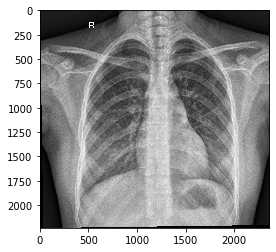

Original Image Array Size: (2234, 2359)


In [4]:
CATEGORIES = ["NORMAL", "PNEUMONIA"] 

for category in CATEGORIES:  # do normal and pneumonia
    
    path = os.path.join(train_data_dir,category)  # create path to normal and pneumonia
        
    print(path)
    for img in os.listdir(path):  # iterate over each image per normal and pneumonia
            
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
            
        plt.imshow(img_array, cmap='gray')  # graph it
            
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!
    
print("Original Image Array Size: {}".format(img_array.shape))

- The raw images are extremely detailed and excellent for processing, however we will need to downsize the image dimensions to help keep processing times realistic.

(Left) - NORMAL  Vs (Right) - PNEUMONIA
---------------------------------------------------------------------------------------------------------------------


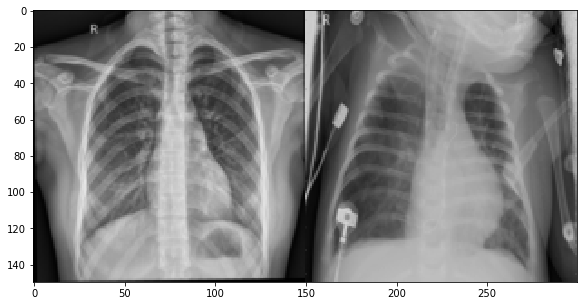

(Left) - NORMAL  Vs (Right) - PNEUMONIA
---------------------------------------------------------------------------------------------------------------------


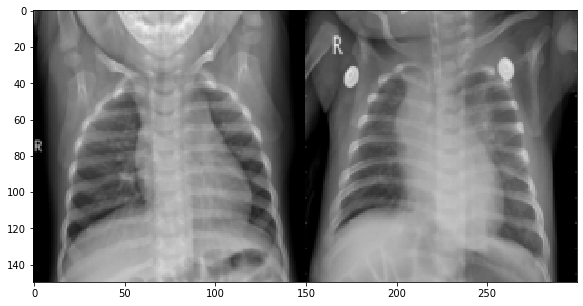

(Left) - NORMAL  Vs (Right) - PNEUMONIA
---------------------------------------------------------------------------------------------------------------------


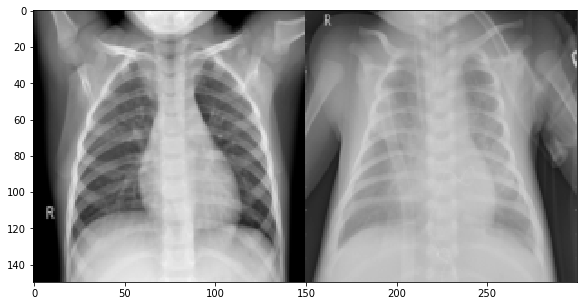

(Left) - NORMAL  Vs (Right) - PNEUMONIA
---------------------------------------------------------------------------------------------------------------------


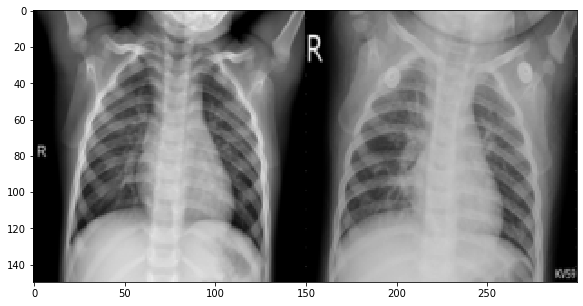

(Left) - NORMAL  Vs (Right) - PNEUMONIA
---------------------------------------------------------------------------------------------------------------------


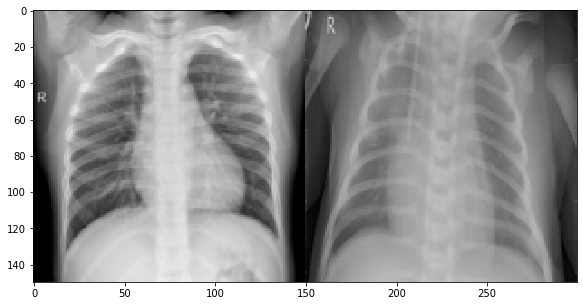

In [5]:
Pimages = os.listdir(train_data_dir + "/PNEUMONIA")
Nimages = os.listdir(train_data_dir + "/NORMAL")

def plotter(i): # grab a pair of images from either label class
    imagep1 = cv2.imread(train_data_dir+"/PNEUMONIA/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(train_data_dir+"/NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - NORMAL  Vs (Right) - PNEUMONIA")
    print("---------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(0,5): # return fives pairs of images
    plotter(i)

- A collection of images, on the left, x-rays classified as normal with no pneumonia present in the lungs, on the right, the x-rays of the pneumonia positive classification.

- Important to note how consistent the image data is. This will help the network train much more confidently on the finer details of the x-ray datasets.

In [6]:
train_data =[]
IMG_SIZE = 150

def create_data(directory,data): # method to create greyscale image data for processing 
    for category in CATEGORIES:  # do normal and pneumonia

        path = os.path.join(directory,category)  # create path to normal and pneumonia
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=normal 1=pneumonia

        for img in tqdm(os.listdir(path)):  # iterate over each image per normal and pneumonia
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                
                data.append([img_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))
            
create_data(train_data_dir,train_data)

100%|██████████| 3876/3876 [00:33<00:00, 116.95it/s]


In [7]:
y_train = [] # create training data set for plotting 

for features,label in train_data:
    y_train.append(label)

y_array = np.asarray(y_train)

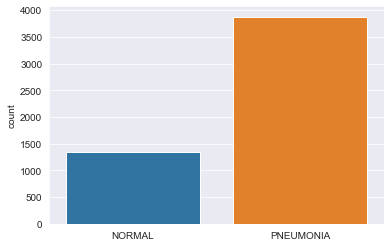

In [8]:
sns.set_style("darkgrid") # plot training class distribution 
ax = sns.countplot(y_array)
ax.set_xticklabels(["NORMAL","PNEUMONIA"])

plt.savefig('label_distribution.png')

- We see how unbalanced the training classes are, the amount of pneumonia cases is almost 3 times greater than the instances of normal cases. 
- In this study I will choose to employ weights on the training dataset during model learning such that all data is remains viable and relevant.

In [13]:
# dimensions of our images.
img_width, img_height = 150, 150

In [14]:
if K.image_data_format() == 'channels_first': # orient image input shape 
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)

In [15]:
# this is the augmentation configuration we will use for training
gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [16]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_gen = ImageDataGenerator(rescale=1. / 255)

In [20]:
def cnn_model(): # this will be the general CNN structure
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    
    return model

model = cnn_model()

In [58]:
model = cnn_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
activation_11 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 64)       

In [21]:
train_batches = gen.flow_from_directory(train_data_dir,model.input_shape[1:3],
                                        color_mode="grayscale",shuffle=True,seed=1,
                                        batch_size=16)

valid_batches = gen.flow_from_directory(validation_data_dir, model.input_shape[1:3],
                                        color_mode="grayscale", shuffle=True,seed=1,
                                        batch_size=16)

test_batches = test_gen.flow_from_directory(test_data_dir, model.input_shape[1:3], shuffle=False,
                                       color_mode="grayscale", batch_size=8)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


- Setting up the general covolution neural network, it is a sequential CNN with 3 2-dimensional convolutional layers and 2 dense layers. I have used the binary crossentropy loss function because our target class is binary. 

# Accuracy and Loss Histories

- I run three seperate CNNs, while changing only the optimization function each time. The optimization functions used are the RMSprop Adma, and Sigmoid functions. 

## RMSPROP CNN

In [55]:
filepath = 'cnn_rmsprop.best.weight.hdf5' # create checkpoint and callback to save best CNN weights 
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=2, 
                              save_best_only=True, 
                              mode='min')
callbacks_list_rmsprop = [checkpoint]

In [56]:
model = cnn_model_rmsprop() 

history_rmsprop = model.fit_generator(train_batches, class_weight={0:1.0, 1:0.4},
                                  steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=valid_batches,
                                  validation_steps=nb_validation_samples // batch_size, 
                                  callbacks=callbacks_list_rmsprop, verbose=1)

Epoch 1/20
326/326 [==============================] - 127s 391ms/step - loss: 0.2417 - acc: 0.8082 - val_loss: 0.6293 - val_acc: 0.7188

Epoch 00001: val_loss improved from inf to 0.62932, saving model to cnn_rmsprop.best.weight.hdf5
Epoch 2/20
326/326 [==============================] - 133s 408ms/step - loss: 0.1626 - acc: 0.8919 - val_loss: 0.7587 - val_acc: 0.6875

Epoch 00002: val_loss did not improve from 0.62932
Epoch 3/20
326/326 [==============================] - 137s 419ms/step - loss: 0.1414 - acc: 0.9085 - val_loss: 0.3354 - val_acc: 0.9375

Epoch 00003: val_loss improved from 0.62932 to 0.33537, saving model to cnn_rmsprop.best.weight.hdf5
Epoch 4/20
326/326 [==============================] - 141s 431ms/step - loss: 0.1284 - acc: 0.9196 - val_loss: 0.6797 - val_acc: 0.6875

Epoch 00004: val_loss did not improve from 0.33537
Epoch 5/20
326/326 [==============================] - 141s 432ms/step - loss: 0.1255 - acc: 0.9245 - val_loss: 1.3854 - val_acc: 0.5625

Epoch 00005: va

In [58]:
def plot_model(model_history, model_name): # create simple plot to graph CNN accuracy and loss history over each epoch
    '''
    Simple function to plot the loss and accuracy of the validation data.
    '''
    sns.set_style("darkgrid")
    plt.style.use('tableau-colorblind10')
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
    
    ax1.plot(model_history.history['acc'])
    ax1.plot(model_history.history['val_acc'])
    ax1.set_title(model_name + ' Model(Rmsprop) Accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')

    ax2.plot(model_history.history['loss'])
    ax2.plot(model_history.history['val_loss'])
    ax2.set_title(model_name + ' Model(Rmsprop) Loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')

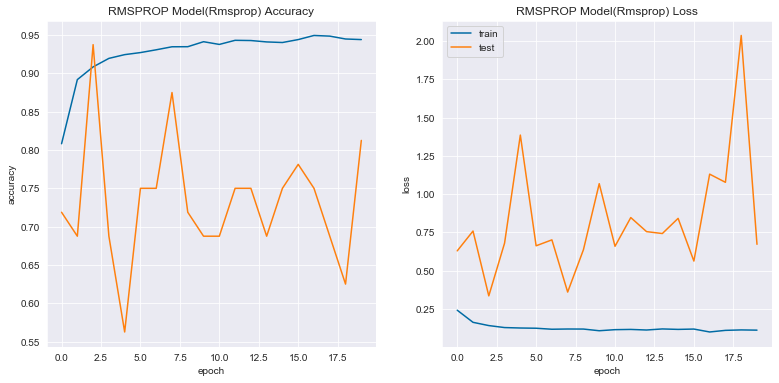

In [59]:
plot_model(history_rmsprop, 'RMSPROP')
plt.savefig('rmsprop_draft_ACCURACY_LOSS.png')

# SIGMOID CNN

In [30]:
filepath = 'cnn_sigmoid.best.weight.hdf5' # create checkpoint and callback to save best CNN weights 
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=2, 
                              save_best_only=True, 
                              mode='min')
callbacks_list_sigmoid = [checkpoint]

In [31]:
model = cnn_model_sigmoid()

history_sigmoid = model.fit_generator(train_batches, class_weight={0:1.0, 1:0.4},
                                  steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=valid_batches,
                                  validation_steps=nb_validation_samples // batch_size, 
                                  callbacks=callbacks_list_sigmoid, verbose=1)

Epoch 1/20
326/326 [==============================] - 131s 401ms/step - loss: 0.3835 - acc: 0.6754 - val_loss: 0.6931 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.69312, saving model to cnn_sigmoid.best.weight.hdf5
Epoch 2/20
326/326 [==============================] - 119s 366ms/step - loss: 0.3817 - acc: 0.7182 - val_loss: 0.6925 - val_acc: 0.5000

Epoch 00002: val_loss improved from 0.69312 to 0.69254, saving model to cnn_sigmoid.best.weight.hdf5
Epoch 3/20
326/326 [==============================] - 118s 361ms/step - loss: 0.3809 - acc: 0.7284 - val_loss: 0.6926 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 0.69254
Epoch 4/20
326/326 [==============================] - 130s 400ms/step - loss: 0.3803 - acc: 0.7392 - val_loss: 0.6909 - val_acc: 0.5000

Epoch 00004: val_loss improved from 0.69254 to 0.69089, saving model to cnn_sigmoid.best.weight.hdf5
Epoch 5/20
326/326 [==============================] - 115s 354ms/step - loss: 0.3787 - acc: 0.7438 - v

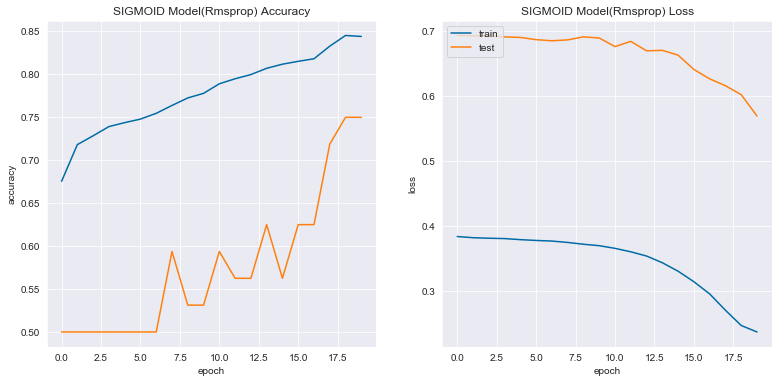

In [33]:
plot_model(history_sigmoid, 'SIGMOID')
plt.savefig('sigmoid_draft_ACCURACY_LOSS.png')

# ADAM CNN

In [34]:
filepath = 'cnn_adam.best.weight.hdf5' # create checkpoint and callback to save best CNN weights 
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=2, 
                              save_best_only=True, 
                              mode='min')
callbacks_list_adam = [checkpoint]

In [35]:
model = cnn_model_adam()

history_adam = model.fit_generator(train_batches, class_weight={0:1.0, 1:0.4},
                                  steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=valid_batches,
                                  validation_steps=nb_validation_samples // batch_size, 
                                  callbacks=callbacks_list_adam, verbose=1)

Epoch 1/20
326/326 [==============================] - 111s 339ms/step - loss: 0.2506 - acc: 0.7951 - val_loss: 0.8713 - val_acc: 0.6250

Epoch 00001: val_loss improved from inf to 0.87126, saving model to cnn_adam.best.weight.hdf5
Epoch 2/20
326/326 [==============================] - 119s 365ms/step - loss: 0.1815 - acc: 0.8696 - val_loss: 0.7348 - val_acc: 0.6875

Epoch 00002: val_loss improved from 0.87126 to 0.73476, saving model to cnn_adam.best.weight.hdf5
Epoch 3/20
326/326 [==============================] - 124s 381ms/step - loss: 0.1531 - acc: 0.8874 - val_loss: 0.9236 - val_acc: 0.7500

Epoch 00003: val_loss did not improve from 0.73476
Epoch 4/20
326/326 [==============================] - 122s 375ms/step - loss: 0.1320 - acc: 0.9084 - val_loss: 1.0199 - val_acc: 0.6250

Epoch 00004: val_loss did not improve from 0.73476
Epoch 5/20
326/326 [==============================] - 115s 353ms/step - loss: 0.1237 - acc: 0.9197 - val_loss: 1.3692 - val_acc: 0.6250

Epoch 00005: val_loss

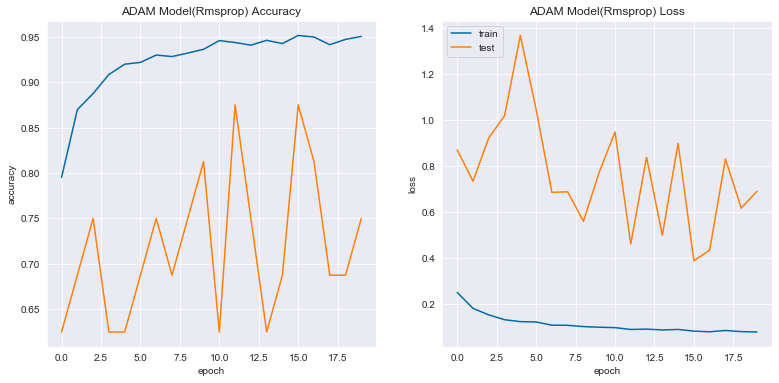

In [36]:
plot_model(history_adam, 'ADAM')
plt.savefig('sigmoid_draft_ACCURACY_LOSS.png')

# LOAD MODELS

In [29]:
sigmoid_history = load_model('final_capstone_sigmoid_opt_draft.h5') # load saved CNN weights 

adam_history = load_model('final_capstone_adam_opt_draft.h5')

rmsprop_history = load_model('final_capstone_rmsprop_opt_draft.h5')

# Training Accuracy

In [31]:
print('TRAINING SET ACCURACY SCORES')

scores_adam_train = adam_history.evaluate_generator(train_batches)
print("\nADAM %s: %.2f%%" % (adam_history.metrics_names[1], scores_adam_train[1]*100))

scores_sigmoid_train = sigmoid_history.evaluate_generator(train_batches)
print("\nSIGMOID %s: %.2f%%" % (sigmoid_history.metrics_names[1], scores_sigmoid_train[1]*100))

scores_rmsprop_train = rmsprop_history.evaluate_generator(train_batches)
print("\nRMSPROP %s: %.2f%%" % (rmsprop_history.metrics_names[1], scores_rmsprop_train[1]*100))

TRAINING SET ACCURACY SCORES

ADAM acc: 95.60%

SIGMOID acc: 87.26%

RMSPROP acc: 91.03%


# Testing Accuracy

In [30]:
print('TESTING SET ACCURACY SCORES')

scores_adam = adam_history.evaluate_generator(test_batches)
print("\nADAM %s: %.2f%%" % (adam_history.metrics_names[1], scores_adam[1]*100))

scores_sigmoid = sigmoid_history.evaluate_generator(test_batches)
print("\nSIGMOID %s: %.2f%%" % (sigmoid_history.metrics_names[1], scores_sigmoid[1]*100))

scores_rmsprop = rmsprop_history.evaluate_generator(test_batches)
print("\nRMSPROP %s: %.2f%%" % (rmsprop_history.metrics_names[1], scores_rmsprop[1]*100))

TESTING SET ACCURACY SCORES

ADAM acc: 90.54%

SIGMOID acc: 82.93%

RMSPROP acc: 91.19%


# Training Loss

In [32]:
print('TRAINING SET LOSS SCORES')

train_loss_adam, train_score_adam = adam_history.evaluate_generator(train_batches)
print("\nADAM loss: ", train_loss_adam)

train_loss_sigmoid, train_score_sigmoid = sigmoid_history.evaluate_generator(train_batches)
print("\nSGD loss: ", train_loss_sigmoid)

train_loss_rsmprop, train_score_rsmprop = rmsprop_history.evaluate_generator(train_batches)
print("\nRMSPROP loss: ", train_loss_rsmprop)

TRAINING SET LOSS SCORES

ADAM loss:  0.11658181843420697

SGD loss:  0.3420448971489456

RMSPROP loss:  0.2742857798431183


# Testing Loss

In [33]:
print('TESTING SET LOSS SCORES')

test_loss_adam, test_score_adam = adam_history.evaluate_generator(test_batches)
print("\nADAM loss: ", test_loss_adam)

test_loss_sigmoid, test_score_sigmoid = sigmoid_history.evaluate_generator(test_batches)
print("\nSGD loss: ", test_loss_sigmoid)

test_loss_rsmprop, test_score_rsmprop = rmsprop_history.evaluate_generator(test_batches)
print("\nRMSPROP loss: ", test_loss_rsmprop)

TESTING SET LOSS SCORES

ADAM loss:  0.31618251936743036

SGD loss:  0.39034908522780126

RMSPROP loss:  0.3102835313751338


## Create Metrics Dictionary

In [34]:
ADAM = {'Train Acc': round(scores_adam_train[1]*100,2), 'Test Acc': round(scores_adam[1]*100,2), 'Train Loss': round(train_loss_adam,2), 'Test Loss': round(test_loss_adam, 2), 'Train/Test Difference': round(scores_adam_train[1]*100-scores_adam[1]*100,2)}
SIGMOID = {'Train Acc': round(scores_sigmoid_train[1]*100,2), 'Test Acc': round(scores_sigmoid[1]*100,2), 'Train Loss': round(train_loss_sigmoid,2), 'Test Loss': round(test_loss_sigmoid, 2), 'Train/Test Difference':round(scores_sigmoid_train[1]*100-scores_sigmoid[1]*100,2)}
RMSPROP = {'Train Acc': round(scores_rmsprop_train[1]*100,2), 'Test Acc': round(scores_rmsprop[1]*100,2), 'Train Loss': round(train_loss_rsmprop,2), 'Test Loss': round(test_loss_rsmprop, 2), 'Train/Test Difference':round(scores_rmsprop_train[1]*100-scores_rmsprop[1]*100,2)}

In [35]:
df = pd.DataFrame([ADAM, SIGMOID, RMSPROP])
df = df.rename({0: 'ADAM', 1: 'SIGMOID', 2: 'RMSPROP'})
df

,Train Acc,Test Acc,Train Loss,Test Loss,Train/Test Difference
ADAM,95.60,90.54,0.12,0.32,5.06
SIGMOID,87.26,82.93,0.34,0.39,4.33
RMSPROP,91.03,91.19,0.27,0.31,-0.16


- We see in the final performance metrics, the Adam and RMSprop optimization functions returned accuracy scores over 90% on the testing set, however the Adam Model seems to overfit. 
- The Sigmoid optimization function does not seem to be the right choice in this context as it did not reach the same accuracy levels on either dataset and seems not generalize well. 

In [37]:
import subprocess

df.to_html('FC_metrics_df.html') # save metrics dataframe
subprocess.call(
    'wkhtmltoimage -f png --width 0 FC_metrics_df.html FC_metrics_df.png', shell=True)

127

## Process testing data for classification reports

- Since our training data was so imbalanced, accuracy may not be the final metric to conclude the viability of these CNNs. Looking at metrics like precision, recall, and F1 score can describe a model's capability in much finer detail.

In [38]:
test_data = [] 

create_data(test_data_dir,test_data)

print("Test Data Instances: {}".format(len(test_data)))

100%|██████████| 390/390 [00:03<00:00, 107.23it/s]

Test Data Instances: 624


In [39]:
y_test = [] # testing label dataset for prediction purposes  

for features,label in test_data:
    y_test.append(label)

In [40]:
p_rmsprop = rmsprop_history.predict(test_batches) 
preds_rmsprop = np.argmax(p_rmsprop, axis=-1)
print(preds_rmsprop.shape)

p_adam = adam_history.predict(test_batches)
preds_adam = np.argmax(p_adam, axis=-1)
print(preds_adam.shape)

p_sigmoid = sigmoid_history.predict(test_batches)
preds_sigmoid = np.argmax(p_sigmoid, axis=-1)
print(preds_sigmoid.shape)

(624,)
(624,)
(624,)


# CLASSIFICATION REPORTS

In [41]:
print('ADAM CNN MODEL')
print(classification_report(y_test, preds_adam))

ADAM CNN MODEL
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       234
           1       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.91      0.90       624



In [42]:
print('SIGMOID CNN MODEL')
print(classification_report(y_test, preds_sigmoid))

SIGMOID CNN MODEL
              precision    recall  f1-score   support

           0       0.74      0.84      0.78       234
           1       0.90      0.82      0.86       390

    accuracy                           0.83       624
   macro avg       0.82      0.83      0.82       624
weighted avg       0.84      0.83      0.83       624



In [43]:
print('RMSPROP CNN MODEL')
print(classification_report(y_test, preds_rmsprop))

RMSPROP CNN MODEL
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       234
           1       0.92      0.95      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.91       624
weighted avg       0.91      0.91      0.91       624



In [44]:
ADAM_2 = {'Recall': .91, 'Precision': .91, 'F1-score': .90}
SIGMOID_2 = {'Recall': .83, 'Precision': .84, 'F1-score': .83}
RMSPROP_2 = {'Recall': .91, 'Precision': .91, 'F1-score': .91}

In [45]:
class_df = pd.DataFrame([ADAM_2, SIGMOID_2, RMSPROP_2])
class_df = class_df.rename({0: 'ADAM', 1: 'SIGMOID', 2: 'RMSPROP'})
class_df

,Recall,Precision,F1-score
ADAM,0.91,0.91,0.90
SIGMOID,0.83,0.84,0.83
RMSPROP,0.91,0.91,0.91


- Given the medical context of this study, I feel it is necessary to prioritize the recall score as it accounts for the amount of false negatives in prediction. Since this represents a supplement method to diagnosis of pneumonia, it would be more detrimental to miss a positive case of pneumonia than mischaracterize a negative case.

- As such, we see a higher recall score of pneumonia cases held by the Adam CNN at 98%.

In [46]:
class_df.to_html('FC_class_df.html') #save report dataframe 
subprocess.call(
    'wkhtmltoimage -f png --width 0 FC_class_df.html FC_class_df.png', shell=True)

127

## Create combined accuracy vs loss history plot

In [61]:
def plot_combined_model(model_history1,model_history2,model_history3):
    '''
    Simple function to plot the loss and accuracy of the validation data.
    '''
    sns.set_style("darkgrid")
    plt.style.use('tableau-colorblind10')
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
    
    ax1.plot(model_history1.history['acc'])
    ax1.plot(model_history2.history['acc'])
    ax1.plot(model_history3.history['acc'])
    
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Train Accuracy')
    ax1.set_xlabel('Epoch')
    
    ax2.plot(model_history1.history['loss'])
    ax2.plot(model_history2.history['loss'])
    ax2.plot(model_history3.history['loss'])
    
    ax2.set_title('CNN Model Loss')
    ax2.set_ylabel('Train Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Adam', 'Sigmoid', 'Rmsprop'], loc='upper right')

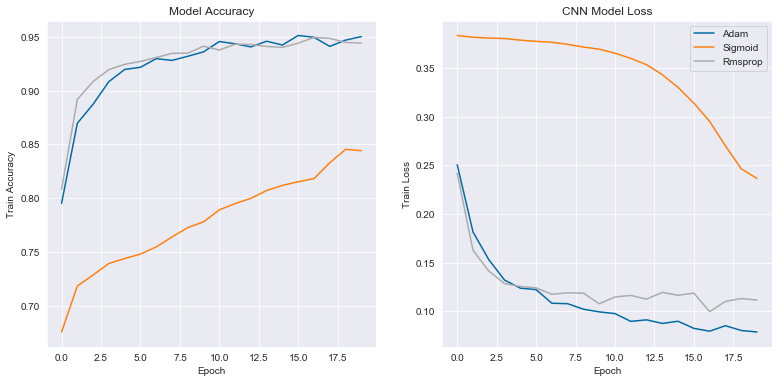

In [62]:
#plot_combined_model(history_adam,history_sigmoid,history_rmsprop)
#plt.savefig('combined_ACCURACY_LOSS.png')

# Prediction 
- Simple demonstration of each CNN's predictive performance

In [47]:
sampled_image1 = '/Users/coreycoole/Desktop/chest_xray/test/NORMAL/IM-0001-0001.jpeg' #NORMAL image
 
sampled_image2 = '/Users/coreycoole/Desktop/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg' #PNEUMONIA image

NORMAL SAMPLE


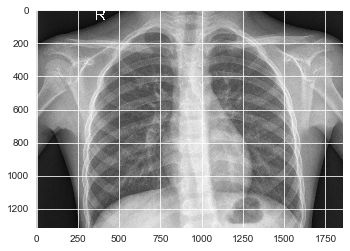

PNEMONIA SAMPLE


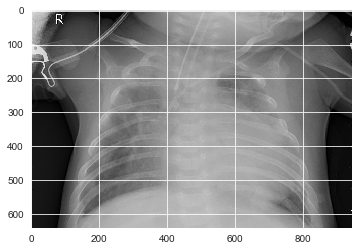

In [48]:
img_array = cv2.imread(sampled_image1 ,cv2.IMREAD_GRAYSCALE)  # convert to array
            
plt.imshow(img_array, cmap='gray')  # graph it
print('NORMAL SAMPLE')            
plt.show()

img_array = cv2.imread(sampled_image2 ,cv2.IMREAD_GRAYSCALE)  # convert to array
            
plt.imshow(img_array, cmap='gray')  # graph it
print('PNEMONIA SAMPLE')            
plt.show()

In [49]:
from skimage import transform
from PIL import Image
import numpy as np

def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (150, 150, 1))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image1 = load(sampled_image1)
image2 = load(sampled_image2)

In [50]:
models = [rmsprop_history, adam_history, sigmoid_history]
model_names = ['RMSPROP', 'ADAM', 'SIGMOID']

In [51]:
def return_predictions(image):
    print('Type Probabilities\n')
    for i, model in enumerate(models):
        
        # dict used to store type name and probability for each model
        # used to grab the max
        quick_dict = {}
        
        print(model_names[i])
        preds = model.predict(image)[0]
        for j, pred in enumerate(preds):
            c_type = j #+ 1
            quick_dict[pred] = c_type
            print('Type {}: {:.2f}'.format(c_type, pred))
            
        max_pred = max(quick_dict.keys())
        print('Prediction: Type {}'.format(quick_dict[max_pred]))
            
        print(' ')

In [52]:
return_predictions(image1)

Type Probabilities

RMSPROP
Type 0: 1.00
Type 1: 0.00
Prediction: Type 0
 
ADAM
Type 0: 0.92
Type 1: 0.08
Prediction: Type 0
 
SIGMOID
Type 0: 0.94
Type 1: 0.04
Prediction: Type 0
 


In [53]:
return_predictions(image2)

Type Probabilities

RMSPROP
Type 0: 0.10
Type 1: 0.88
Prediction: Type 1
 
ADAM
Type 0: 0.00
Type 1: 1.00
Prediction: Type 1
 
SIGMOID
Type 0: 0.13
Type 1: 0.90
Prediction: Type 1
 


- While each network predicted the sample correctly, we see how the Adam CNN predicted the pneumonia sample most significantly. 